In [8]:
import torch
import torch.nn as nn 
from torchvision import transforms


import pytorch_lightning as pl

from lightning_models_dict import OEModel, VanillaModel
# from evaluator import Evaluator
import data
from fgcv_aircraft_code import Dataset_fromTxtFile as txtfiledataset

import pytorch_ood

In [10]:
DATASET_ROOT = data.dataset_root('planes', 'split1')


ID_train_dataset = txtfiledataset.Dataset_fromTxtFile(
    DATASET_ROOT + "/ID_trainset.txt", transform=transforms.ToTensor(),is_fgcvaircraft=True
)

ID_test_dataset = txtfiledataset.Dataset_fromTxtFile(
    DATASET_ROOT + "/ID_testset.txt", transform=transforms.ToTensor(), is_fgcvaircraft=True
)

OOD_test_dataset = txtfiledataset.Dataset_fromTxtFile(
    DATASET_ROOT + "/OOD_testset.txt", 
    transform=transforms.ToTensor(),
    is_fgcvaircraft=True
)

In [12]:
ID_train_dataset[0][0].shape

torch.Size([3, 675, 1024])

In [ ]:
min_px = 0
max_px = 0

for dataset in [ID_train_dataset, ID_test_dataset, OOD_test_dataset]:
    for image, _ in dataset:
        

In [4]:
from lightning_models import MixupModel


detector=pytorch_ood.detector.Softmax
model = MixupModel(79, None, 100, 'cutmix', detector)
# model.load_from_checkpoint(
#     './models/split1-2022-08-17-oe/1/epoch=10.ckpt',
#     n_id_classes=79,
#     objective=None,
#     max_epochs=100,
#     detector=detector)

model.load_state_dict(torch.load('./models/split1-2022-08-24-mixup/1/epoch=99.ckpt')['state_dict'])

<All keys matched successfully>

In [16]:
ID_test_set = data.testing_id_planes('split1', 20, 'big')

# ID_training_set, _ = data.training_data('split1', 20, 'big', 1)

model.model.to('cuda')
model.eval()

def id_accuracy(limit=-1):

    running_correct = 0.0
    running_total = 0.0

    with torch.no_grad():
        for i, (X, y) in enumerate(ID_test_set):
            # if limit != -1 and i >= limit:
            #     break

            X, y = X.to('cuda'), y.to('cuda')

            _, preds = model(X).softmax(dim=1).max(dim=1)

            if i == 0: print(preds - y)

            running_correct += preds.eq(y).sum().item()
            running_total += y.shape[0]

    return running_correct / running_total * 100


id_accuracy()


tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
         0,  0], device='cuda:0')


91.04024297646166

In [18]:
"Epoch 99, 22 DP", 90.8883826879271
"Epoch 99, 19 DDP", 86.67425968109339
"Epoch 99, 19 DP", 90.81245254365984

90.85041761579346

In [16]:
from evaluator import Evaluator
detector=pytorch_ood.detector.Softmax

In [5]:

def intra_level_ood(model, save_folder):
    AUROCs={"L1": [], "L2": [], "All": []}

    for experiment in range(1,6):
        model.load_state_dict(torch.load(f'./models/{save_folder}/{experiment}/epoch=99.ckpt')['state_dict'])
        l3_planes = data.testing_ood_planes('split1', 20, 'big', 3, set_unknown=False)
        others = [data.testing_ood_planes('split1', 20, 'big', level) for level in [1, 2]]

        ev = Evaluator(model, pytorch_ood.detector.Softmax, 'split1', 20, 'big')
        results = ev._eval(detector(model), l3_planes, others)

        AUROCs["L1"].append(results[0]['AUROC'])
        AUROCs["L2"].append(results[1]['AUROC'])
        AUROCs["All"].append(results[2]['AUROC'])

    for key, value in AUROCs.items():
        print(f"L3 vs. {key}: {sum(value) / len(value)}")


model = OEModel(79, None, 100, detector)
intra_level_ood(model, 'split1-2022-08-22-oe')

KeyboardInterrupt: 

In [12]:
model = OEModel(79, None, 100, detector)
model.load_state_dict(torch.load('./models/split1-2022-08-22-oe/1/epoch=99.ckpt')['state_dict'])
l3_planes = data.testing_ood_planes('split1', 20, 'big', 3, set_unknown=False)
others = [data.testing_ood_planes('split1', 20, 'big', level) for level in [1, 2]]

ev = Evaluator(model, pytorch_ood.detector.Softmax, 'split1', 20, 'big')
ev._eval(detector(model), l3_planes, others)

[{'AUROC': 0.7906412482261658,
  'AUPR-IN': 0.8286167979240417,
  'AUPR-OUT': 0.7365365624427795,
  'ACC95TPR': 0.7238461375236511,
  'FPR95TPR': 0.6380000114440918},
 {'AUROC': 0.6411625146865845,
  'AUPR-IN': 0.7197020649909973,
  'AUPR-OUT': 0.5126123428344727,
  'ACC95TPR': 0.6223077178001404,
  'FPR95TPR': 0.9020000100135803},
 {'AUROC': 0.7159019708633423,
  'AUPR-IN': 0.873706042766571,
  'AUPR-OUT': 0.43988296389579773,
  'ACC95TPR': 0.7723809480667114,
  'FPR95TPR': 0.7960000038146973}]

In [11]:
model = MixupModel(79, None, 100, 'cutmix', detector)
model.load_state_dict(torch.load('./models/split1-2022-08-24-mixup/1/epoch=99.ckpt')['state_dict'])

l3_planes = data.testing_ood_planes('split1', 20, 'big', 3, set_unknown=False)
others = [data.testing_ood_planes('split1', 20, 'big', level) for level in [1, 2]]

ev = Evaluator(model, pytorch_ood.detector.Softmax, 'split1', 20, 'big')
ev._eval(detector(model), l3_planes, others)

[{'AUROC': 0.8276600241661072,
  'AUPR-IN': 0.868133008480072,
  'AUPR-OUT': 0.7665073871612549,
  'ACC95TPR': 0.7538461685180664,
  'FPR95TPR': 0.5600000023841858},
 {'AUROC': 0.6306474804878235,
  'AUPR-IN': 0.7348119616508484,
  'AUPR-OUT': 0.4978116750717163,
  'ACC95TPR': 0.6246153712272644,
  'FPR95TPR': 0.8960000276565552},
 {'AUROC': 0.7291537523269653,
  'AUPR-IN': 0.8904196619987488,
  'AUPR-OUT': 0.43597468733787537,
  'ACC95TPR': 0.7704761624336243,
  'FPR95TPR': 0.8040000200271606}]

In [14]:
model = MixupModel(79, None, 100, 'cutmix', detector)
model.load_state_dict(torch.load('./models/split1-2022-08-25-ternary/1/epoch=99.ckpt')['state_dict'])

l3_planes = data.testing_ood_planes('split1', 20, 'big', 3, set_unknown=False)
others = [data.testing_ood_planes('split1', 20, 'big', level) for level in [1, 2]]

ev = Evaluator(model, pytorch_ood.detector.Softmax, 'split1', 20, 'big')
ev._eval(detector(model), l3_planes, others)

[{'AUROC': 0.83809494972229,
  'AUPR-IN': 0.8611668944358826,
  'AUPR-OUT': 0.804518461227417,
  'ACC95TPR': 0.7730769515037537,
  'FPR95TPR': 0.5099999904632568},
 {'AUROC': 0.6673162579536438,
  'AUPR-IN': 0.7511739730834961,
  'AUPR-OUT': 0.5766536593437195,
  'ACC95TPR': 0.6630769371986389,
  'FPR95TPR': 0.7960000038146973},
 {'AUROC': 0.7527056336402893,
  'AUPR-IN': 0.8929933905601501,
  'AUPR-OUT': 0.5232096314430237,
  'ACC95TPR': 0.7814285755157471,
  'FPR95TPR': 0.7580000162124634}]

In [13]:
for exp in range(1, 6):
    model = VanillaModel(79, None, 100, detector)
    model.load_state_dict(torch.load(f'./models/split1-2022-08-22-vanilla/{exp}/epoch=99.ckpt')['state_dict'])
    l3_planes = data.testing_ood_planes('split1', 20, 'big', 3, set_unknown=False)
    others = [data.testing_ood_planes('split1', 20, 'big', level) for level in [1, 2]]

    ev = Evaluator(model, pytorch_ood.detector.Softmax, 'split1', 20, 'big')
    ev._eval(detector(model), l3_planes, others)

[{'AUROC': 0.7604599595069885,
  'AUPR-IN': 0.8042856454849243,
  'AUPR-OUT': 0.6921142339706421,
  'ACC95TPR': 0.7323076725006104,
  'FPR95TPR': 0.6159999966621399},
 {'AUROC': 0.6279687881469727,
  'AUPR-IN': 0.7245003581047058,
  'AUPR-OUT': 0.45463383197784424,
  'ACC95TPR': 0.5969230532646179,
  'FPR95TPR': 0.9679999947547913},
 {'AUROC': 0.6942143440246582,
  'AUPR-IN': 0.8657789826393127,
  'AUPR-OUT': 0.37055107951164246,
  'ACC95TPR': 0.7452380657196045,
  'FPR95TPR': 0.9100000262260437}]

In [24]:
Evaluator(model, pytorch_ood.detector.Softmax, 'split1', 20, 'big')()

[0.9328018223234624,
 0.9435450434684753,
 0.8501482605934143,
 0.7961320877075195,
 0.8728670477867126,
 0.15793469548225403,
 0.5489749312400818,
 0.561123788356781,
 0.48823082447052,
 0.9999750852584839,
 0.9996589422225952,
 0.9739803075790405,
 0.9912049174308777,
 0.0,
 0.0004761904710903764,
 0.17714285850524902,
 0.01904761977493763]

In [5]:
from torchvision.datasets import ImageFolder

detector = pytorch_ood.detector.Softmax

model = OEModel(79, None, None, detector)
model.load_state_dict(torch.load('./models/split1/2022-08-22-oe/1/epoch=99.ckpt')['state_dict'])

planes = data.testing_ood_planes('split1', 20, 'big', -1, set_unknown=False)
birds_ds = ImageFolder(
    '/data/birds/CUB_200_2011/images', 
    data.get_transforms('big', False), 
    target_transform=pytorch_ood.utils.ToUnknown(),
)

birds = torch.utils.data.DataLoader(birds_ds, batch_size=20, shuffle=True)

ev = Evaluator(model, detector, 'split1', 20, 'big')
ev._eval(detector(model), planes, [birds])

[{'AUROC': 0.9999996423721313,
  'AUPR-IN': 0.9999998807907104,
  'AUPR-OUT': 0.9999967217445374,
  'ACC95TPR': 0.9541205763816833,
  'FPR95TPR': 0.0}]

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.neighbors import KernelDensity
import numpy as np

#detector=pytorch_ood.detector.Softmax
# model_detector = detector(model)


def create_kde_figure(model, loader_dict):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    max = -1

    with torch.no_grad():
        # model = load_model('ring')


        for name, loader in loader_dict.items():

            score_holder = -1

            for i, (X, _) in enumerate(loader):
                if i>= 100: break

                scores = model.forward(X.cuda()).softmax(dim=1).max(dim=1).values
                # scores = -model_detector(X.cuda())
                scores = scores.cpu().numpy()

                if i == 0: print(name, scores)

                max = np.max([max, scores.max()])

                if isinstance(score_holder, int): 
                    score_holder = scores.copy()
                else:
                    score_holder = np.concatenate([score_holder, scores], axis=None)

            kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(score_holder.reshape(-1, 1))
            x_range = np.arange(0, 1, 0.005).reshape(-1, 1)
            axes[0].plot(x_range, np.exp(kde.score_samples(x_range)), label=name)
            axes[0].legend()

            x_range = np.arange(0.8, 1, 0.005).reshape(-1, 1)
            axes[1].plot(x_range, np.exp(kde.score_samples(x_range)), label=name)
            axes[1].legend()

            # plt.hist(score_holder, bins=20)


1 [0.44498628 0.561039   0.46166596 0.9324179  0.5078724  0.67328227
 0.9836827  0.3478569  0.16157107 0.99951315 0.98979074 0.58540076
 0.94461745 0.8407567  0.99005705 0.51181734 0.32971227 0.6516779
 0.9838944  0.9569446 ]
2 [0.79225796 0.99147874 0.9942895  0.77373135 0.9998368  0.23630227
 0.9843717  0.9709085  0.38784844 0.98915184 0.9069984  0.9750978
 0.48947588 0.2753306  0.99934727 0.9832903  0.66856766 0.4894617
 0.19586778 0.93520933]
3 [0.9689417  0.9980064  0.9997799  0.98590255 0.55592835 0.9993017
 0.9888847  0.999648   0.9858738  0.9781091  0.9477109  0.97687495
 0.96561515 0.9995413  0.9984457  0.96973026 0.9977181  0.67503065
 0.9874419  0.9774035 ]
ID Planes [0.6031322  0.999964   0.99998283 0.99982375 0.9910958  0.9996991
 0.9999207  0.7631439  0.99996674 0.9999578  0.99998355 0.99999034
 0.999894   0.9966809  0.9999908  0.99999654 0.99997854 0.9998435
 0.999941   0.9998516 ]


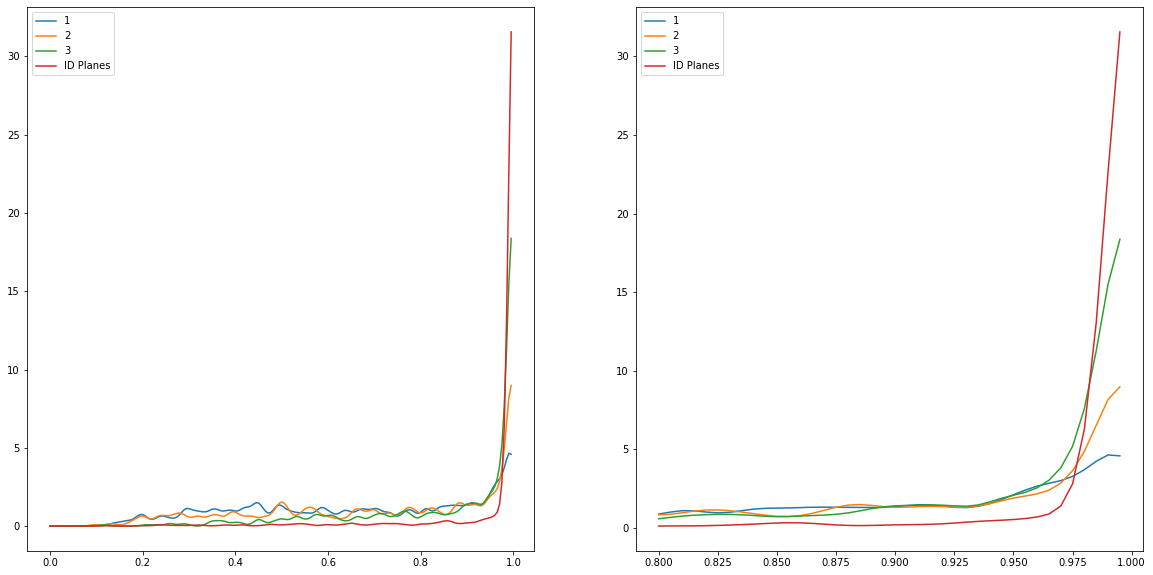

In [56]:
from lightning_models import TernaryModel

detector = pytorch_ood.detector.Softmax
model = TernaryModel(79, None, 100, 'cutmix', detector)
model.load_state_dict(torch.load('./models/split1-2022-08-25-ternary/1/epoch=99.ckpt')['state_dict'])

model.cuda()
levels = [1, 2, 3]
by_level = {level: data.testing_ood_planes('split1', 20, 'big', level, set_unknown=True) for level in levels}
by_level['ID Planes'] = data.testing_id_planes('split1', 20, 'big')

create_kde_figure(model, by_level)

1 [0.28381234 0.5699486  0.81818247 0.8056843  0.98546696 0.32917917
 0.4598231  0.9679023  0.60413885 0.5883464  0.19196269 0.5954669
 0.35523984 0.731806   0.7689178  0.48541802 0.6143813  0.9930829
 0.5276604  0.06460996]
2 [0.99907136 0.5096229  0.4702599  0.77416116 0.8749743  0.20078796
 0.46656    0.48339462 0.70745695 0.5100201  0.6035514  0.6329245
 0.34314102 0.47588125 0.3763472  0.5889115  0.38302362 0.42136312
 0.947052   0.999736  ]
3 [0.645149   0.48646036 0.80903965 0.959783   0.6326137  0.8526266
 0.78695124 0.94404656 0.47054178 0.7351529  0.69674677 0.50868994
 0.88376117 0.99663204 0.99806947 0.9991611  0.9993393  0.970975
 0.15585403 0.5262307 ]
ID Planes [0.9999927  0.999843   0.99803215 0.99981135 0.8338653  0.99996626
 0.9695199  0.9953467  0.99973196 0.9999647  0.99978703 0.99934465
 0.9999976  0.9789179  0.99973994 0.99646556 0.8349438  0.9999232
 0.99860793 0.9997794 ]


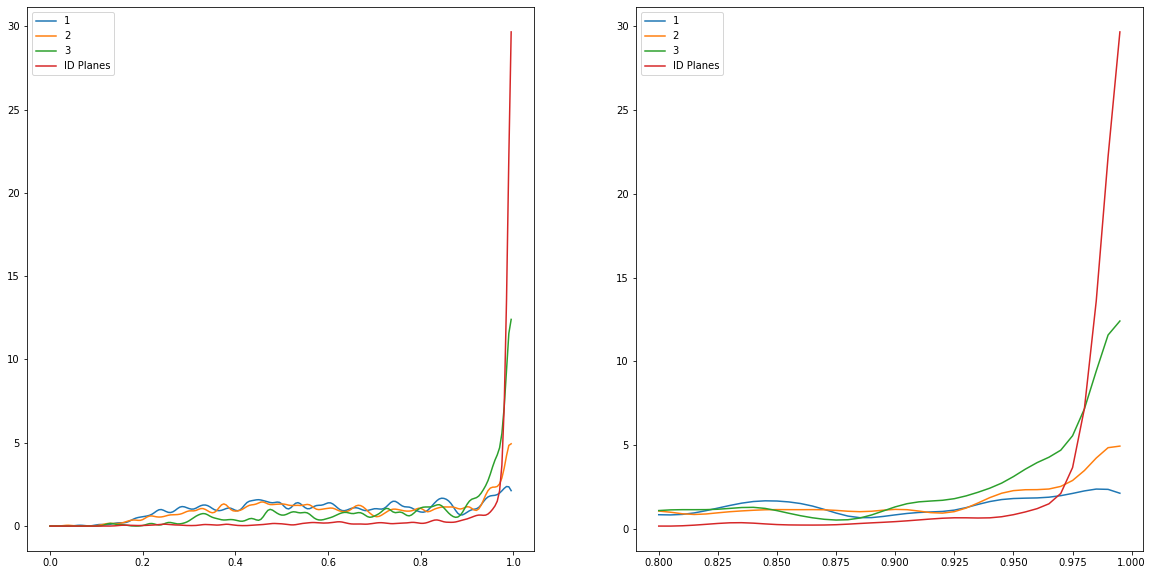

In [60]:
detector = pytorch_ood.detector.Softmax
model = VanillaModel(79, None, 100, detector)
model.load_state_dict(torch.load('./models/split1-2022-08-22-vanilla/1/epoch=99.ckpt')['state_dict'])

model.cuda()
levels = [1, 2, 3]
by_level = {level: data.testing_ood_planes('split1', 20, 'big', level, set_unknown=True) for level in levels}
by_level['ID Planes'] = data.testing_id_planes('split1', 20, 'big')

create_kde_figure(model, by_level)

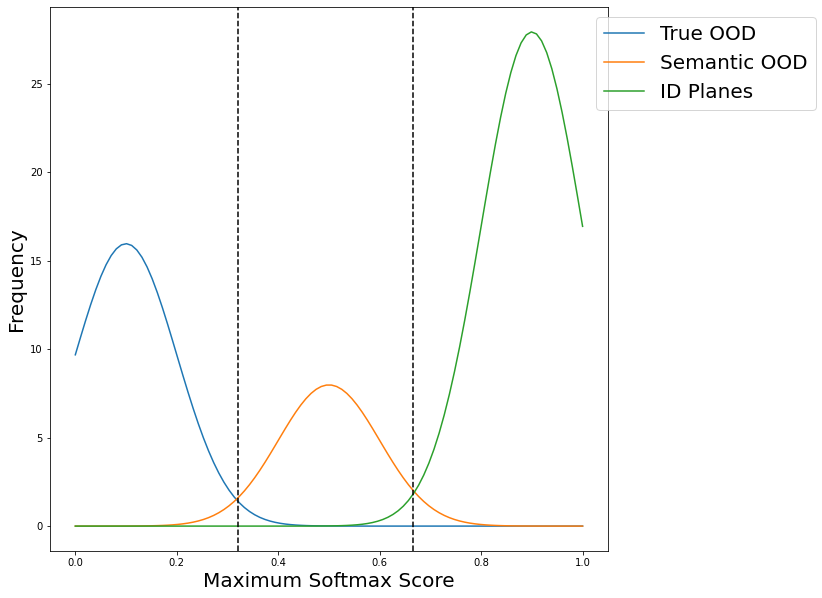

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

plt.figure(figsize=(10,10))

for name, mu, height in zip(["True OOD", "Semantic OOD", "ID Planes"], [0.1, 0.5, 0.9], [4, 2, 7]):
    variance = 0.01
    sigma = math.sqrt(variance)
    x = np.linspace(0, 1, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma) * height, label=name)
    plt.legend(loc='upper right', bbox_to_anchor=((1.39, 1)), fontsize=20)

plt.axvline(x=0.32, color='k', ls='--')
plt.axvline(x=0.665, color='k', ls='--')

plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Maximum Softmax Score", fontsize=20)

plt.show()

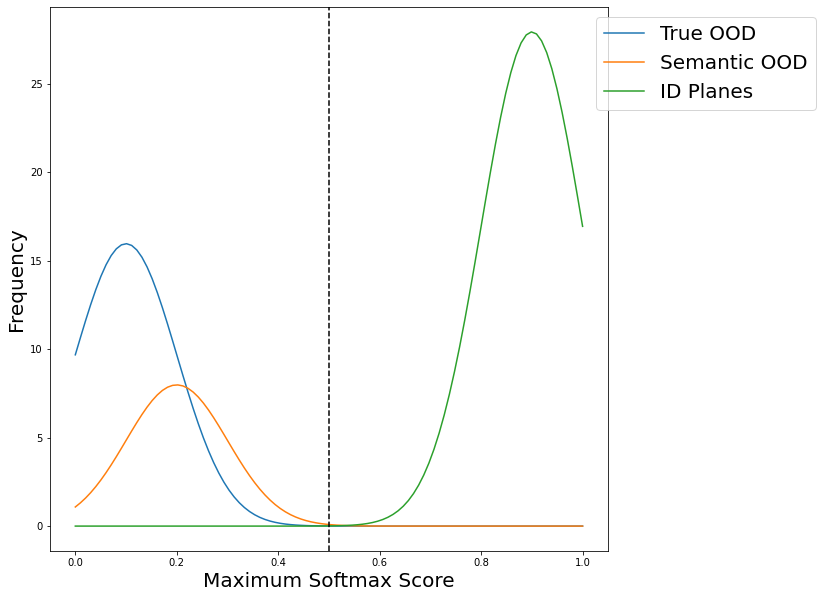

In [19]:
plt.figure(figsize=(10,10))

for name, mu, height in zip(["True OOD", "Semantic OOD", "ID Planes"], [0.1, 0.2, 0.9], [4, 2, 7]):
    variance = 0.01
    sigma = math.sqrt(variance)
    x = np.linspace(0, 1, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma) * height, label=name)
    plt.legend(loc='upper right', bbox_to_anchor=((1.39, 1)), fontsize=20)

plt.axvline(x=0.5, color='k', ls='--')

plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Maximum Softmax Score", fontsize=20) 

plt.show()

In [4]:
test_loaders = {
    "ID Planes": data.testing_id_planes('split1', 20, 'big'), 
    "OOD Planes": data.testing_ood_planes('split1', 20, 'big', -1, set_unknown=True), 
    "Places365": data.places('big', 20),
    "Cars": data.cars('big', 20),
    "Dogs": data.dogs('big', 20)
}

model.cuda()
create_kde_figure(model, test_loaders)

NameError: name 'data' is not defined

In [2]:
from torchvision.datasets import ImageFolder
from data import get_transforms
from torch.utils.data import DataLoader

birds_dataset = ImageFolder('/data/birds/CUB_200_2011/images', transform=get_transforms('big', False), target_transform=pytorch_ood.utils.ToUnknown())
birds_loader = DataLoader(birds_dataset, 20, True, num_workers=20)

test_loaders = {
    "Birds": birds_loader,
    "OOD Planes": data.testing_ood_planes('split1', 20, 'big', -1),
    "ID Planes": data.testing_id_planes('split1', 20, 'big')
}

create_kde_figure(model, test_loaders)

NameError: name 'create_kde_figure' is not defined

In [57]:
from lightning_models import QuadModel

detector = pytorch_ood.detector.Softmax
model = QuadModel(79, None, 100, 'cutmix', detector)
model.load_state_dict(torch.load('./models/split1/2022-09-01-quad/4/epoch=99.ckpt')['state_dict'])

<All keys matched successfully>

In [58]:
Evaluator(model, detector, 'split1', 20, 'big')()

[0.9347000759301443,
 0.9444888830184937,
 0.8907228112220764,
 0.8056002259254456,
 0.890937864780426,
 0.16021260619163513,
 0.34700074791908264,
 0.6032649874687195,
 0.40508732199668884,
 0.998031497001648,
 0.9988856911659241,
 0.9736261963844299,
 0.9901811480522156,
 0.003809523768723011,
 0.0009523809421807528,
 0.1604761928319931,
 0.04285714402794838]

In [ ]:
Evaluator(model, detector, 'split1', 20, 'big')._eval(detector(model), test_loaders['ID Planes'], [test_loaders['Birds']])

[{'AUROC': 0.9978814125061035,
  'AUPR-IN': 0.9997463822364807,
  'AUPR-OUT': 0.9882566928863525,
  'ACC95TPR': 0.9539488554000854,
  'FPR95TPR': 0.011009871028363705}]

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('./planes_results/results_planes_vanilla.csv')

for model in ['cutmix', 'energy', 'oe', 'quad', 'ternary']:
    tmp = pd.read_csv(f'./planes_results/results_planes_{model}.csv')

    df = pd.concat([df, tmp])


tmp = df[['split', 'loss','detector', 'ID_accuracy'] + [col for col in df.columns if 'AUROC' in col]].groupby(['split', 'loss', 'detector']).mean()
tmp.groupby(['loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_AUROC  l2_AUROC  l3_AUROC  all_AUROC  \
loss    detector                                                               
cutmix  Softmax               93.23     94.93     90.51     79.31      89.63   
energy  NegativeEnergy        90.71     88.39     83.18     68.24      81.62   
oe      Softmax               91.06     88.37     87.46     72.63      84.19   
        softmax_temp          91.06     89.09     85.70     62.93      81.45   
quad    Softmax               92.88     94.81     89.86     79.73      89.43   
ternary Softmax               93.22     93.64     88.77     80.81      88.86   
vanilla Softmax               92.05     89.14     88.43     75.39      85.62   

                        dogs_AUROC  places_AUROC  cars_AUROC  cfg_AUROC  
loss    detector                                                         
cutmix  Softmax              99.99         99.95       97.86      99.27  
energy  NegativeEnergy       86.12         78.38       38.34      67.61  
oe      Softmax             100.00        100.00       99.99     100.00  
        softmax_temp        100.00        100.00       99.99     100.00  
quad    Softmax              99.95         99.96       98.36      99.42  
ternary Softmax              92.59         94.05       92.15      92.93  
vanilla Softmax              97.66         92.05       56.18      81.96

In [3]:
tmp = df[['split', 'loss','detector', 'ID_accuracy'] + [col for col in df.columns if 'FPR' in col]].groupby(['split', 'loss', 'detector']).mean()
tmp.groupby(['loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_FPR95TPR  l2_FPR95TPR  l3_FPR95TPR  \
loss    detector                                                             
cutmix  Softmax               93.23        13.77        33.19        59.38   
energy  NegativeEnergy        90.71        42.08        62.95        84.68   
oe      Softmax               91.06        33.03        39.08        75.33   
        softmax_temp          91.06        36.62        49.96        89.16   
quad    Softmax               92.88        14.78        35.23        55.19   
ternary Softmax               93.22        21.11        41.59        49.93   
vanilla Softmax               92.05        32.56        38.88        68.28   

                        all_FPR95TPR  dogs_FPR95TPR  places_FPR95TPR  \
loss    detector                                                       
cutmix  Softmax                40.88           0.00             0.00   
energy  NegativeEnergy         69.72          33.20            54.91   
oe      Softmax                54.64           0.00             0.00   
        softmax_temp           73.20           0.00             0.00   
quad    Softmax                42.32           0.13             0.02   
ternary Softmax                43.27          27.93            27.20   
vanilla Softmax                50.94          14.15            46.53   

                        cars_FPR95TPR  cfg_FPR95TPR  
loss    detector                                     
cutmix  Softmax                 14.21          1.64  
energy  NegativeEnergy          97.24         91.41  
oe      Softmax                  0.04          0.00  
        softmax_temp             0.03          0.00  
quad    Softmax                  9.02          1.39  
ternary Softmax                 45.60         34.81  
vanilla Softmax                 89.30         78.23

In [4]:
df = pd.read_csv('./results.csv')

df[['loss','detector', 'ID_accuracy'] + [col for col in df.columns if 'AUROC' in col]].groupby(['loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_AUROC  l2_AUROC  l3_AUROC  all_AUROC  \
loss    detector                                                               
cutmix  Softmax               93.17     94.86     90.59     79.44      89.67   
energy  NegativeEnergy        90.72     87.87     83.56     68.15      81.51   
        Softmax               90.88     91.81     81.66     76.77      84.36   
oe      Softmax               91.06     88.37     87.46     72.63      84.19   
        softmax_temp          91.06     89.09     85.70     62.93      81.45   
quad    Softmax               92.88     94.81     89.86     79.73      89.43   
ternary Softmax               93.22     93.64     88.77     80.81      88.86   
vanilla Softmax               92.05     89.14     88.43     75.39      85.62   

                        dogs_AUROC  places_AUROC  cars_AUROC  cfg_AUROC  
loss    detector                                                         
cutmix  Softmax              99.99         99.95       97.68      99.20  
energy  NegativeEnergy       92.33         86.13       49.48      75.98  
        Softmax              99.72         98.58       81.12      93.14  
oe      Softmax             100.00        100.00       99.99     100.00  
        softmax_temp        100.00        100.00       99.99     100.00  
quad    Softmax              99.95         99.96       98.36      99.42  
ternary Softmax              92.59         94.05       92.15      92.93  
vanilla Softmax              97.66         92.05       56.18      81.96

In [2]:
df = pd.read_csv('./results.csv')

df[['split', 'loss','detector', 'ID_accuracy'] + [col for col in df.columns if 'AUROC' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_AUROC  l2_AUROC  l3_AUROC  \
split  loss    detector                                                    
split1 cutmix  Softmax               93.64     94.75     87.54     79.99   
       energy  Softmax               90.88     91.81     81.66     76.77   
       oe      Softmax               91.26     91.36     83.96     75.89   
               softmax_temp          91.26     93.56     80.97     65.31   
       quad    Softmax               93.59     94.45     85.23     79.06   
       ternary Softmax               93.83     94.66     85.51     81.33   
       vanilla Softmax               92.10     91.90     83.28     80.38   
split2 cutmix  Softmax               92.84     96.25     88.00     76.92   
       energy  NegativeEnergy        90.89     83.58     82.09     61.97   
       oe      Softmax               90.87     87.05     88.08     75.43   
               softmax_temp          90.87     84.31     84.64     62.01   
       quad    Softmax               92.51     96.45     87.40     78.66   
       ternary Softmax               92.84     95.62     84.73     79.93   
       vanilla Softmax               92.12     90.68     89.44     76.09   
split3 cutmix  Softmax               92.63     93.72     90.76     80.08   
       energy  NegativeEnergy        90.06     88.72     83.33     64.31   
       oe      Softmax               90.90     88.41     88.05     70.39   
               softmax_temp          90.90     88.79     88.73     60.87   
       quad    Softmax               92.48     94.08     91.34     79.21   
       ternary Softmax               92.51     93.43     89.79     79.87   
       vanilla Softmax               91.72     88.69     88.64     75.41   
split4 cutmix  Softmax               93.65     94.70     95.43     80.88   
       energy  NegativeEnergy        90.77     88.73     88.87     72.77   
       oe      Softmax               91.23     86.68     89.74     68.82   
               softmax_temp          91.23     89.69     88.45     63.52   
       quad    Softmax               92.94     94.26     95.49     81.99   
       ternary Softmax               93.68     90.85     95.07     82.10   
       vanilla Softmax               92.27     85.29     92.37     69.69   

                               all_AUROC  dogs_AUROC  places_AUROC  \
split  loss    detector                                              
split1 cutmix  Softmax             88.49      100.00         99.95   
       energy  Softmax             84.36       99.72         98.58   
       oe      Softmax             84.86      100.00        100.00   
               softmax_temp        82.04      100.00        100.00   
       quad    Softmax             87.27       99.94         99.94   
       ternary Softmax             88.00       96.97         98.01   
       vanilla Softmax             85.87       98.19         94.00   
split2 cutmix  Softmax             89.50       99.98         99.90   
       energy  NegativeEnergy      78.74       95.73         90.85   
       oe      Softmax             85.09      100.00        100.00   
               softmax_temp        79.97      100.00        100.00   
       quad    Softmax             89.72       99.99         99.97   
       ternary Softmax             88.67       88.61         92.08   
       vanilla Softmax             87.33       97.61         91.75   
split3 cutmix  Softmax             88.93       99.97         99.97   
       energy  NegativeEnergy      80.10       94.26         88.77   
       oe      Softmax             83.36      100.00        100.00   
               softmax_temp        81.15      100.00        100.00   
       quad    Softmax             89.03       99.87         99.95   
       ternary Softmax             88.41       90.60         92.48   
       vanilla Softmax             85.05       97.85         90.95   
split4 cutmix  Softmax             91.54      100.00         99.97   
       energy  NegativeEnergy      84.79       95.83         89.10   


In [3]:
df[['split', 'loss','detector', 'ID_accuracy'] + [col for col in df.columns if 'FPR' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_FPR95TPR  l2_FPR95TPR  \
split  loss    detector                                                
split1 cutmix  Softmax               93.64        13.50        45.43   
       energy  Softmax               90.88        23.94        57.64   
       oe      Softmax               91.26        25.85        55.04   
               softmax_temp          91.26        22.59        72.63   
       quad    Softmax               93.59        15.31        53.16   
       ternary Softmax               93.83        13.98        51.33   
       vanilla Softmax               92.10        22.38        61.23   
split2 cutmix  Softmax               92.84        10.75        46.53   
       energy  NegativeEnergy        90.89        50.85        68.76   
       oe      Softmax               90.87        34.55        38.22   
               softmax_temp          90.87        46.70        51.40   
       quad    Softmax               92.51         9.66        47.01   
       ternary Softmax               92.84        12.23        63.04   
       vanilla Softmax               92.12        24.67        38.32   
split3 cutmix  Softmax               92.63        15.60        32.85   
       energy  NegativeEnergy        90.06        41.85        66.04   
       oe      Softmax               90.90        33.46        36.51   
               softmax_temp          90.90        41.29        39.44   
       quad    Softmax               92.48        15.03        29.21   
       ternary Softmax               92.51        19.27        38.29   
       vanilla Softmax               91.72        31.52        35.04   
split4 cutmix  Softmax               93.65        15.39        12.48   
       energy  NegativeEnergy        90.77        42.34        36.95   
       oe      Softmax               91.23        38.26        26.56   
               softmax_temp          91.23        35.90        36.35   
       quad    Softmax               92.94        19.11        11.55   
       ternary Softmax               93.68        38.96        13.72   
       vanilla Softmax               92.27        51.67        20.94   

                               l3_FPR95TPR  all_FPR95TPR  dogs_FPR95TPR  \
split  loss    detector                                                   
split1 cutmix  Softmax               60.19         44.48           0.00   
       energy  Softmax               65.24         52.23           1.14   
       oe      Softmax               66.34         51.37           0.00   
               softmax_temp          89.07         74.32           0.00   
       quad    Softmax               60.46         51.62           0.10   
       ternary Softmax               48.39         45.98          13.74   
       vanilla Softmax               54.56         49.10           9.07   
split2 cutmix  Softmax               68.54         48.26           0.00   
       energy  NegativeEnergy        87.06         72.69          12.90   
       oe      Softmax               68.12         46.61           0.00   
               softmax_temp          83.53         65.28           0.00   
       quad    Softmax               55.70         45.27           0.00   
       ternary Softmax               50.98         47.04          33.15   
       vanilla Softmax               69.30         44.51          15.37   
split3 cutmix  Softmax               58.41         42.09           0.00   
       energy  NegativeEnergy        94.74         81.22          17.57   
       oe      Softmax               89.60         63.28           0.00   
               softmax_temp          95.88         83.05           0.00   
       quad    Softmax               62.75         42.52           0.36   
       ternary Softmax               59.90         45.42          36.27   
       vanilla Softmax               74.73         52.24          12.18   
split4 cutmix  Softmax               44.13         30.35           0.00   
       energy  NegativeEnergy        75.78         57.04          14.0

In [4]:
quad_search_df = pd.read_csv('./results_ships_quad_search.csv')

quad_search_df[['delta', 'split', 'loss','detector', 'ID_accuracy'] + [col for col in quad_search_df.columns if 'AUROC' in col]].groupby(['delta', 'split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_AUROC  l2_AUROC  all_AUROC  \
delta split    loss detector                                               
0.1   military quad Softmax         95.36     95.01     81.06      93.06   
1.0   military quad Softmax         95.36     97.25     85.87      95.66   
5.0   military quad Softmax         95.40     95.80     79.21      93.48   
10.0  military quad Softmax         95.05     96.75     80.66      94.50   
100.0 military quad Softmax         95.19     95.90     81.36      93.87   

                              dogs_AUROC  places_AUROC  cars_AUROC  cfg_AUROC  
delta split    loss detector                                                   
0.1   military quad Softmax        98.49         94.49       99.22      97.40  
1.0   military quad Softmax        98.65         95.02       98.69      97.45  
5.0   military quad Softmax        98.91         95.90       99.04      97.95  
10.0  military quad Softmax        98.81         95.40       99.28      97.83  
100.0 military quad Softmax        99.09         96.30       99.27      98.22

In [5]:
ships_df = pd.read_csv('./results_ships.csv')

ships_df[['split', 'loss','detector', 'ID_accuracy'] + [col for col in ships_df.columns if 'AUROC' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_AUROC  l2_AUROC  all_AUROC  \
split    loss    detector                                                     
civ      energy  NegativeEnergy        71.14     54.62     46.02      53.42   
                 Softmax               75.45     57.75     45.84      56.08   
         oe      Softmax               81.09     72.37     59.64      70.59   
         vanilla Softmax               80.63     70.82     56.47      68.81   
hard1    energy  NegativeEnergy        62.06     49.15     47.51      48.00   
                 Softmax               53.47     48.39     46.00      46.71   
         oe      Softmax               76.21     75.35     76.26      75.99   
         vanilla Softmax               75.14     75.27     73.57      74.08   
hard2    energy  NegativeEnergy        58.19     47.96     47.54      47.66   
                 Softmax               63.64     53.51     52.73      52.96   
         oe      Softmax               77.80     76.65     73.74      74.57   
         vanilla Softmax               76.59     77.40     72.51      73.90   
military cutmix  Softmax               95.15     93.99     79.51      91.96   
         energy  NegativeEnergy        94.16     85.20     70.66      83.17   
         oe      Softmax               94.12     96.95     85.48      95.35   
                 softmax_temp          94.12     97.86     85.81      96.17   
         quad    Softmax               95.46     96.47     83.27      94.63   
         ternary Softmax               95.24     91.49     79.67      89.83   
         vanilla Softmax               93.81     89.54     76.87      87.77   

                                 dogs_AUROC  places_AUROC  cars_AUROC  \
split    loss    detector                                               
civ      energy  NegativeEnergy        0.23          0.27        0.12   
                 Softmax               0.33          0.29        0.23   
         oe      Softmax             100.00         99.96      100.00   
         vanilla Softmax              76.38         67.48       69.32   
hard1    energy  NegativeEnergy        0.04          0.07        0.02   
                 Softmax               0.02          0.11        0.00   
         oe      Softmax             100.00         99.97      100.00   
         vanilla Softmax              75.66         67.11       65.14   
hard2    energy  NegativeEnergy        0.06          0.09        0.03   
                 Softmax               0.08          0.07        0.04   
         oe      Softmax             100.00         99.97      100.00   
         vanilla Softmax              78.62         74.57       51.11   
military cutmix  Softmax              97.36         93.06       97.78   
         energy  NegativeEnergy       96.16         77.07       78.03   
         oe      Softmax              99.54         96.90       99.34   
                 softmax_temp         99.54         96.92       99.36   
         quad    Softmax              98.22         95.17       97.99   
         ternary Softmax              94.89         93.79       95.41   
         vanilla Softmax              73.62         63.91       58.35   

                                 cfg_AUROC  
split    loss    detector                   
civ      energy  NegativeEnergy       0.21  
                 Softmax              0.28  
         oe      Softmax             99.98  
         vanilla Softmax             71.06  
hard1    energy  NegativeEnergy       0.05  
                 Softmax              0.04  
         oe      Softmax             99.99  
         vanilla Softmax             69.30  
hard2    energy  NegativeEnergy       0.06  
                 Softmax              0.06  
         oe      Softmax             99.99  
         vanilla Softmax             68.10  
military cutmix  Softmax             96.06  
         energy  NegativeEnergy      83.75  
         oe      Softmax             98.59  
                 softmax_temp        98.61  
         quad    Softmax     

In [6]:
ships_df[['split', 'loss','detector', 'ID_accuracy'] + [col for col in ships_df.columns if 'FPR' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_FPR95TPR  l2_FPR95TPR  \
split    loss    detector                                                
civ      energy  NegativeEnergy        71.14        99.26        97.10   
                 Softmax               75.45        99.41        98.02   
         oe      Softmax               81.09        75.74        89.13   
         vanilla Softmax               80.63        70.04        90.79   
hard1    energy  NegativeEnergy        62.06        97.81        98.43   
                 Softmax               53.47        98.08        98.08   
         oe      Softmax               76.21        73.95        74.13   
         vanilla Softmax               75.14        72.80        80.31   
hard2    energy  NegativeEnergy        58.19        97.07        97.33   
                 Softmax               63.64        94.97        97.28   
         oe      Softmax               77.80        77.22        81.38   
         vanilla Softmax               76.59        73.52        85.97   
military cutmix  Softmax               95.15        28.85        83.11   
         energy  NegativeEnergy        94.16        52.02        87.86   
         oe      Softmax               94.12        13.98        58.31   
                 softmax_temp          94.12        11.15        61.71   
         quad    Softmax               95.46        14.69        71.80   
         ternary Softmax               95.24        37.51        77.86   
         vanilla Softmax               93.81        41.03        88.41   

                                 all_FPR95TPR  dogs_FPR95TPR  places_FPR95TPR  \
split    loss    detector                                                       
civ      energy  NegativeEnergy         99.26          99.99            99.99   
                 Softmax                99.41         100.00            99.98   
         oe      Softmax                79.05           0.01             0.02   
         vanilla Softmax                76.61          65.37            76.70   
hard1    energy  NegativeEnergy         98.32         100.00           100.00   
                 Softmax                98.08         100.00           100.00   
         oe      Softmax                74.08           0.00             0.01   
         vanilla Softmax                77.75          64.75            79.27   
hard2    energy  NegativeEnergy         97.18         100.00           100.00   
                 Softmax                96.97         100.00           100.00   
         oe      Softmax                80.17           0.00             0.04   
         vanilla Softmax                82.38          60.31            66.08   
military cutmix  Softmax                50.00          14.69            30.48   
         energy  NegativeEnergy         62.10          16.44            69.40   
         oe      Softmax                21.75           2.03            11.84   
                 softmax_temp           22.04           1.94            11.87   
         quad    Softmax                25.64           9.03            22.56   
         ternary Softmax                47.48          24.76            29.87   
         vanilla Softmax                53.11          73.45            82.54   

                                 cars_FPR95TPR  cfg_FPR95TPR  
split    loss    detector                                     
civ      energy  NegativeEnergy          99.99         99.99  
                 Softmax                 99.98         99.98  
         oe      Softmax                  0.01          0.02  
         vanilla Softmax                 76.34         74.70  
hard1    energy  NegativeEnergy         100.00        100.00  
                 Softmax                100.00        100.00  
         oe      Softmax                  0.00          0.00  
         vanilla Softmax                 73.72         73.83  
hard2    energy  NegativeEnergy         100.00        100.00  
                 Softmax                100.00        100.00  
         oe      Sof

In [5]:
delta_5 = pd.read_csv('./results_energy_estimation.csv', names=df.columns)
delta_5[['split', 'loss','detector', 'ID_accuracy'] + [col for col in delta_5.columns if 'AUROC' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_AUROC  l2_AUROC  l3_AUROC  \
split loss   detector                                                    
-1000 energy NegativeEnergy         1.25     66.68     66.68     68.58   
-100  energy NegativeEnergy         2.97     37.34     52.44     56.48   
-50   energy NegativeEnergy         6.30     41.25     48.89     51.80   
-25   energy NegativeEnergy        57.45     58.69     52.33     44.79   
-10   energy NegativeEnergy        92.01     75.53     69.96     59.02   
-5    energy NegativeEnergy        91.95     74.89     75.12     63.04   

                             all_AUROC  dogs_AUROC  places_AUROC  cars_AUROC  \
split loss   detector                                                          
-1000 energy NegativeEnergy      92.85       66.74         66.74       66.74   
-100  energy NegativeEnergy      47.65        0.38          1.44        4.50   
-50   energy NegativeEnergy      46.67        0.40          0.74        2.32   
-25   energy NegativeEnergy      52.96        0.19          0.21        0.33   
-10   energy NegativeEnergy      69.48        0.00          0.00        0.00   
-5    energy NegativeEnergy      72.15        0.00          0.00        0.01   

                             cfg_AUROC  
split loss   detector                   
-1000 energy NegativeEnergy      68.73  
-100  energy NegativeEnergy       2.11  
-50   energy NegativeEnergy       1.15  
-25   energy NegativeEnergy       0.24  
-10   energy NegativeEnergy       0.00  
-5    energy NegativeEnergy       0.00

In [22]:
delta_5[['split', 'loss','detector', 'ID_accuracy'] + [col for col in delta_5.columns if 'FPR' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_FPR95TPR  l2_FPR95TPR  l3_FPR95TPR  \
split  loss detector                                                       
split1 quad Softmax         93.44        14.88        46.73        49.67   

                      all_FPR95TPR  dogs_FPR95TPR  places_FPR95TPR  \
split  loss detector                                                 
split1 quad Softmax          42.66           0.01             0.01   

                      cars_FPR95TPR  cfg_FPR95TPR  
split  loss detector                               
split1 quad Softmax           10.55          2.12

In [9]:
gamma_1 = pd.read_csv('./results_gamma_1.csv', names=df.columns)
gamma_1[['split', 'loss','detector', 'ID_accuracy'] + [col for col in gamma_1.columns if 'AUROC' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_AUROC  l2_AUROC  l3_AUROC  all_AUROC  \
split  loss    detector                                                         
split1 ternary Softmax         93.44     94.42     82.41     81.25      86.71   

                         dogs_AUROC  places_AUROC  cars_AUROC  cfg_AUROC  
split  loss    detector                                                   
split1 ternary Softmax        98.65          99.6       96.17      98.14

In [10]:
gamma_1[['split', 'loss','detector', 'ID_accuracy'] + [col for col in gamma_1.columns if 'FPR' in col]].groupby(['split', 'loss', 'detector']).mean().round(4) * 100

ID_accuracy  l1_FPR95TPR  l2_FPR95TPR  l3_FPR95TPR  \
split  loss    detector                                                       
split1 ternary Softmax         93.44        14.26        66.55        52.57   

                         all_FPR95TPR  dogs_FPR95TPR  places_FPR95TPR  \
split  loss    detector                                                 
split1 ternary Softmax          54.94           9.21             1.76   

                         cars_FPR95TPR  cfg_FPR95TPR  
split  loss    detector                               
split1 ternary Softmax           27.06         10.68

## Plots

In [1]:
import data
import numpy as np

In [10]:
loader = data.testing_id_planes('split1', 20, 'big', True)

[tensor([[[-0.3883, -0.4054, -0.3883,  ...,  0.2453,  0.2282,  0.2453],
          [-0.3883, -0.3883, -0.3541,  ...,  0.2453,  0.2282,  0.2282],
          [-0.3712, -0.3541, -0.3541,  ...,  0.2453,  0.2282,  0.2453],
          ...,
          [-1.0048, -1.0219, -0.9705,  ..., -1.0562, -1.0048, -0.9192],
          [-0.9192, -0.9363, -0.9705,  ..., -1.0733, -1.0219, -0.9020],
          [-0.9192, -0.9020, -0.9705,  ..., -1.0219, -0.9705, -0.9877]],
 
         [[-0.1800, -0.1975, -0.1800,  ...,  0.4853,  0.4678,  0.4853],
          [-0.1800, -0.1800, -0.1450,  ...,  0.4853,  0.4678,  0.4678],
          [-0.1625, -0.1450, -0.1450,  ...,  0.4853,  0.4678,  0.4853],
          ...,
          [-0.8803, -0.8978, -0.8277,  ..., -0.7927, -0.7227, -0.6176],
          [-0.8452, -0.8627, -0.8978,  ..., -0.7752, -0.7227, -0.5826],
          [-0.8978, -0.8627, -0.8978,  ..., -0.7052, -0.6527, -0.6702]],
 
         [[ 0.4265,  0.4091,  0.4265,  ...,  0.9494,  0.9319,  0.9319],
          [ 0.3916,  0.4091,

In [11]:

X = torch.stack([loader.__getitem__(i)[0] for i in range(9)])
supp_x = torch.stack([loader.__getitem__(i)[0] for i in range(9, 18)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 447.5, 447.5, -0.5)

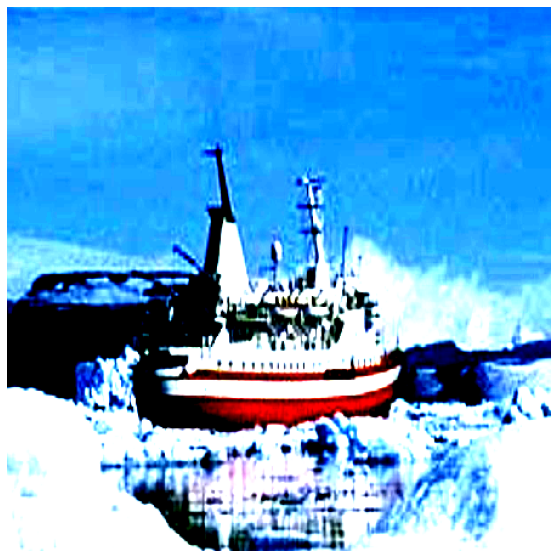

In [37]:
plt.figure(figsize=(10, 10))
plt.imshow(oe_x[6].permute(1, 2, 0).numpy())
plt.axis('off')

In [ ]:
X.shape

torch.Size([20, 3, 448, 448])

In [1]:
import data
from fgcv_aircraft_code import Dataset_fromTxtFile as txtfiledataset


ID_train_dataset = txtfiledataset.Dataset_fromTxtFile(
    data.dataset_root('planes', 'split1') + "/ID_trainset.txt", is_fgcvaircraft=True
)



14


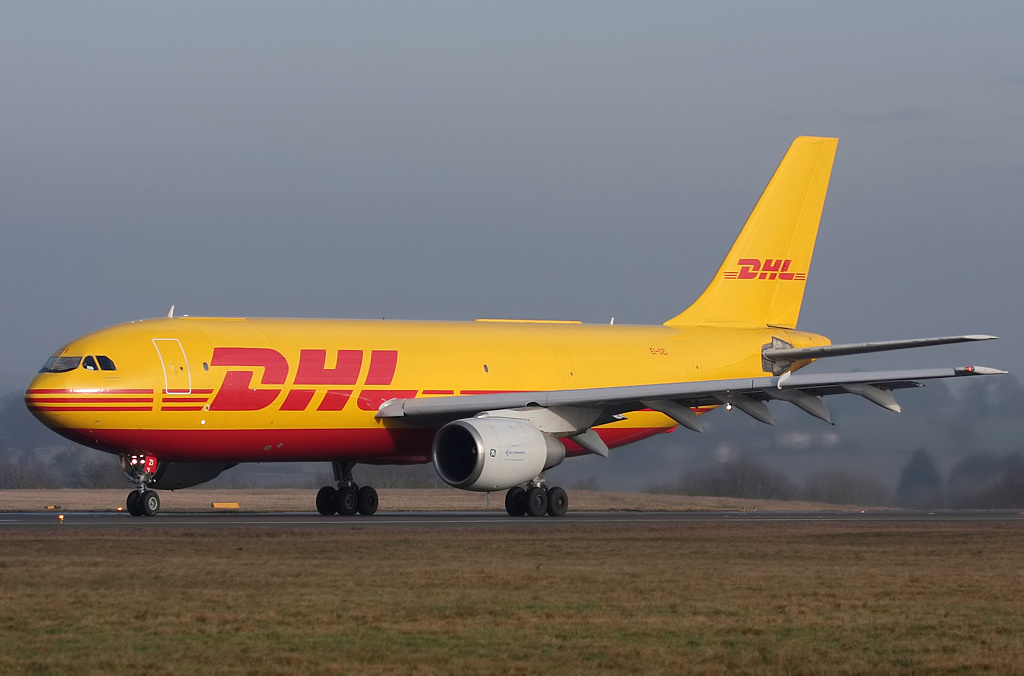

In [5]:
X1 = ID_train_dataset[500]
print(X1[1])
X1[0]

15


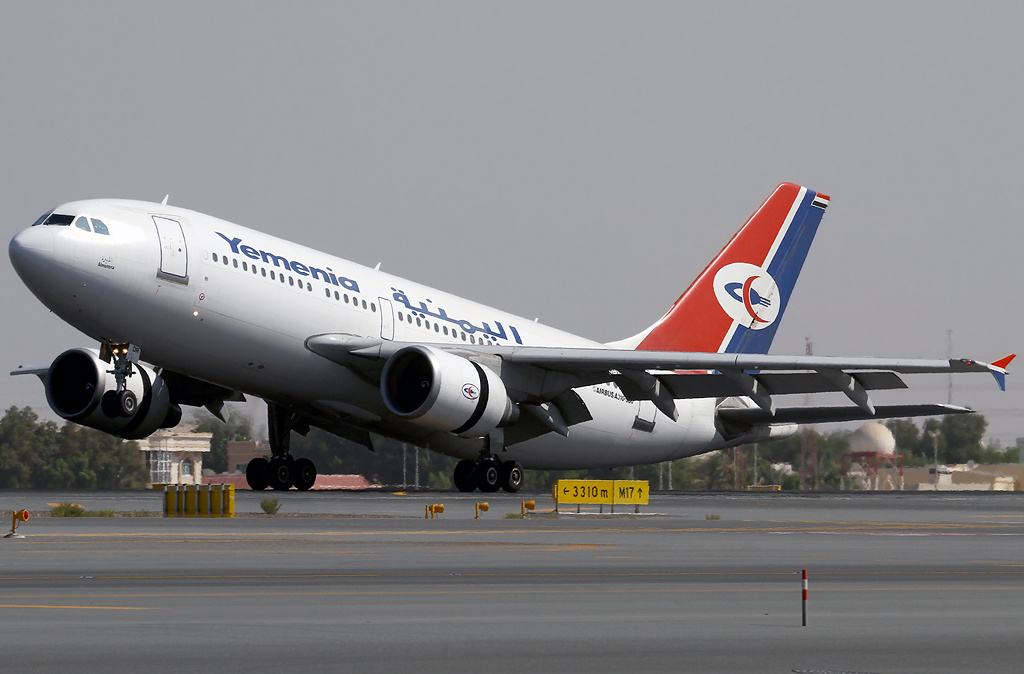

In [4]:
X2 = ID_train_dataset[501]
print(X2[1])
X2[0]

In [8]:
import torchvision.transforms as transforms

transform_test = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.CenterCrop(448),
        transforms.ToTensor()
    ]
)

X1 = transform_test(X1).unsqueeze(0)
X2 = transform_test(X2).unsqueeze(0)

In [1]:
from data import rand_bbox
import numpy as np

def cutmix(X, supp_x):

    mix_id_id_x = X.clone().detach()
    for i in range(X.shape[0]):

        lam_id_id = np.random.beta(2, 2)

        bbx1, bby1, bbx2, bby2 = rand_bbox(X.size(), lam_id_id)
        lam_id_id = 1 - (
            (bbx2 - bbx1) * (bby2 - bby1) / (X.size()[-1] * X.size()[-2])
        )

        mix_id_id_x[i, :, bbx1:bbx2, bby1:bby2] = supp_x[i, :, bbx1:bbx2, bby1:bby2]

    return mix_id_id_x



ImportError: cannot import name 'rand_bbox' from 'data' (/home/noah2/work/planes/data.py)

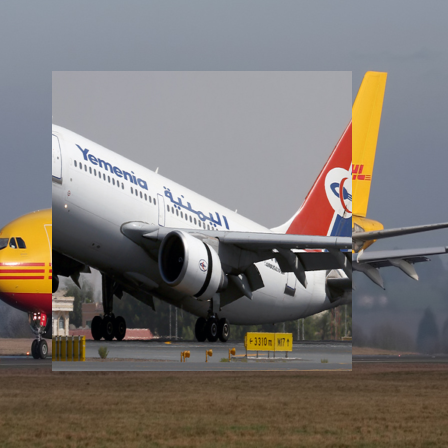

In [13]:
transforms.ToPILImage()(cutmix(X1, X2).squeeze(0))

In [4]:
from torchvision.datasets import ImageFolder

OOD_train_dataset = ImageFolder(
    root="/data/imagenet/ILSVRC/Data/CLS-LOC/train/",
)

In [18]:
n=2300

print(OOD_train_dataset[281*n][1])
OOD_train_dataset[281*n][0] 

503


In [13]:
def plot_mixes(mixed):
    num_row = 3
    num_col = 3
    fig, axes = plt.subplots(num_row, num_col, figsize=(5*num_col,5*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.axis('off')
        ax.imshow(mixed[i].permute((1, 2, 0)).numpy())
        #predicted_label = model.predict(x_raw_train_adv[i+offset].reshape((1,64,64,3))).argmax()
        #ax.set_title(‘predicted Label : {}’.format(_LABELS[predicted_label]))
    plt.tight_layout()
    plt.savefig('Cutmix_grid.png')
    plt.show()

In [17]:
plot_mixes(cutmix(X, supp_x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [56]:
oe_loader = data.infinite_imagenet('split1', 20, 'big')
oe_x, _ = next(oe_loader)

plot_mixes(cutmix(X, oe_x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [66]:
t[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])

In [7]:
import data
dl = data.training_id('ships', 'military', 1, 'big')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


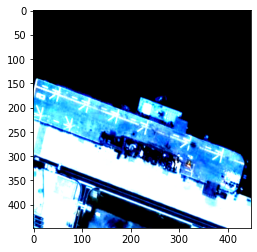

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.imshow(next(iter(dl))[0].squeeze().permute(1, 2, 0).detach().numpy())